# Deniz Kulağı (Abalone) Yaş Tahmini  

   &ensp;<sup>Edanur Yılmaz (121521014)</sup>  
   &ensp;<sup>24.11.2024</sup>

## İçerik
• [Veri İncelemesi ve Ön İşlemesi](#Veri-İncelemesi-ve-Ön-İşlemesi)  
• [Basit Doğrusal Regresyon](#1.Basit-Doğrusal-Regresyon)    
• [Çoklu Doğrusal Regresyon](#2.Çoklu-Doğrusal-Regresyon)    
    &emsp;- [Özellik Eliminasyonu (Feature Selection)](#2.1.Özellik-Eliminasyonu-(Feature-Selection))   
    &emsp;- [K-Fold](#2.2.K-Fold)  
    &emsp;- [Grid Search Cross-Validation ile Hiperparametre Ayarlama](#2.3.Grid-Search-Cross-Validation-ile-Hiperparametre-Ayarlama)    
• [Çoklu Doğrusal Olmayan Regresyon (MLPRegressor)](#3.Çoklu-Doğrusal-Olmayan-Regresyon)    
    &emsp;- [Grid Search Cross-Validation ile Hiperparametre Ayarlama](#3.1.Grid-Search-Cross-Validation-ile-Hiperparametre-Ayarlama)    
• [K-En Yakın Komşular Algoritması](#4.K-En-Yakın-Komşular-Algoritması)  
    &emsp;- [Grid Search Cross-Validation ile Hiperparametre Ayarlama](#4.1.Grid-Search-Cross-Validation-ile-Hiperparametre-Ayarlama)

#### Gerekli Kütüphaneler
Kullanacağımız kütüphaneleri ve belirli paketleri(kütüphane ve modülden) ekliyoruz.

In [1]:
import pandas as pd
import numpy as np
import random
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

### Veri İncelemesi ve Ön İşlemesi  
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

Kullanılan veri seti: [Abalone Dataset by Rodolfo Mendes](https://www.kaggle.com/datasets/rodolfomendes/abalone-dataset) 

Kaynak: [Abalone - UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/1/abalone)

<sup>Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994) 
"The Population Biology of Abalone (Haliotis species) in Tasmania. I. Blacklip Abalone (H. rubra) from the North Coast and Islands of Bass Strait", Sea Fisheries Division,   
Technical Report No. 48 (ISSN 1034-3288)</sup>

In [2]:
abalone_data = pd.read_csv("abalone.csv")

Veri setinin; 1 'object', 6 'float64', 1 de 'int64' veri tipinde 8 farklı değişkenden oluştuğunu ve kayıp gözlem bulundurmadığını görebiliyoruz.

In [3]:
abalone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


Veriyi setinin, cinsiyet('M', 'F', 'I')('I' burada infant yani bebek anlamındadır.), uzunluk, çap, yükseklik, tam ağırlık, soyulmuş ağırlık, iç organ ağırlığı, kabuk ağırlığı, halka sayısı(1.5 eklendiğinde yıl olarak yaşı vermektedir.) değişkenlerinden oluştuğunu görebiliyoruz.

In [4]:
abalone_data

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


Halka sayısı tahmini değil yaş tahmini olarak tanımlamak istediğim için halka sayısına 1.5 ekleyerek bir yaş sütunu oluşturuyorum.

In [5]:
abalone_data["value"] = 1.5
abalone_data["Rings"] = abalone_data["Rings"] + abalone_data["value"]
abalone_data.drop("value", axis='columns', inplace=True)
abalone_data = abalone_data.rename({"Rings":"Age"}, axis='columns')

In [6]:
abalone_data

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,8.5
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,12.5
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,11.5
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,10.5
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,11.5


Cinsiyet değişkeninin 'object' olduğunu biliyoruz. Aldığı değerlere bakalım.

In [7]:
abalone_data["Sex"].unique() # I: Infant

array(['M', 'F', 'I'], dtype=object)

Cinsiyet değişkeninin aldığı değerlere karşılık gelen sayısal değerler atıyoruz.   
(Sayısal değer ataması daha zor olan bir durum olsaydı panda kütüphanesindeki 'get.dummies' fonksiyonunu kullanabilirdik.)

In [8]:
def binary_map(x):
    return x.map({"M" : 1,
                  "F" : 2,
                  "I" : 3})

In [9]:
abalone_data["Sex"] = binary_map(abalone_data["Sex"])

In [10]:
abalone_data

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,16.5
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,8.5
2,2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,10.5
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,11.5
4,3,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,8.5
...,...,...,...,...,...,...,...,...,...
4172,2,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,12.5
4173,1,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,11.5
4174,1,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,10.5
4175,2,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,11.5


Veri setinde kayıp gözlemimizin olmadığını biliyoruz.

In [11]:
abalone_data.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Age               0
dtype: int64

Bütün veri setinin %1'i kadar değere NaN atıyorum.

In [12]:
xy = [(row, col) for row in range(abalone_data.shape[0]) for col in range(abalone_data.shape[1])]
random.seed(121521014)
for row, col in random.sample(xy, int(round(.01*len(xy)))):
    abalone_data.iat[row, col] = np.nan

In [13]:
abalone_data.isnull().sum(), abalone_data.isnull().sum().sum()

(Sex               37
 Length            52
 Diameter          44
 Height            37
 Whole weight      39
 Shucked weight    41
 Viscera weight    44
 Shell weight      39
 Age               43
 dtype: int64,
 376)

<Axes: >

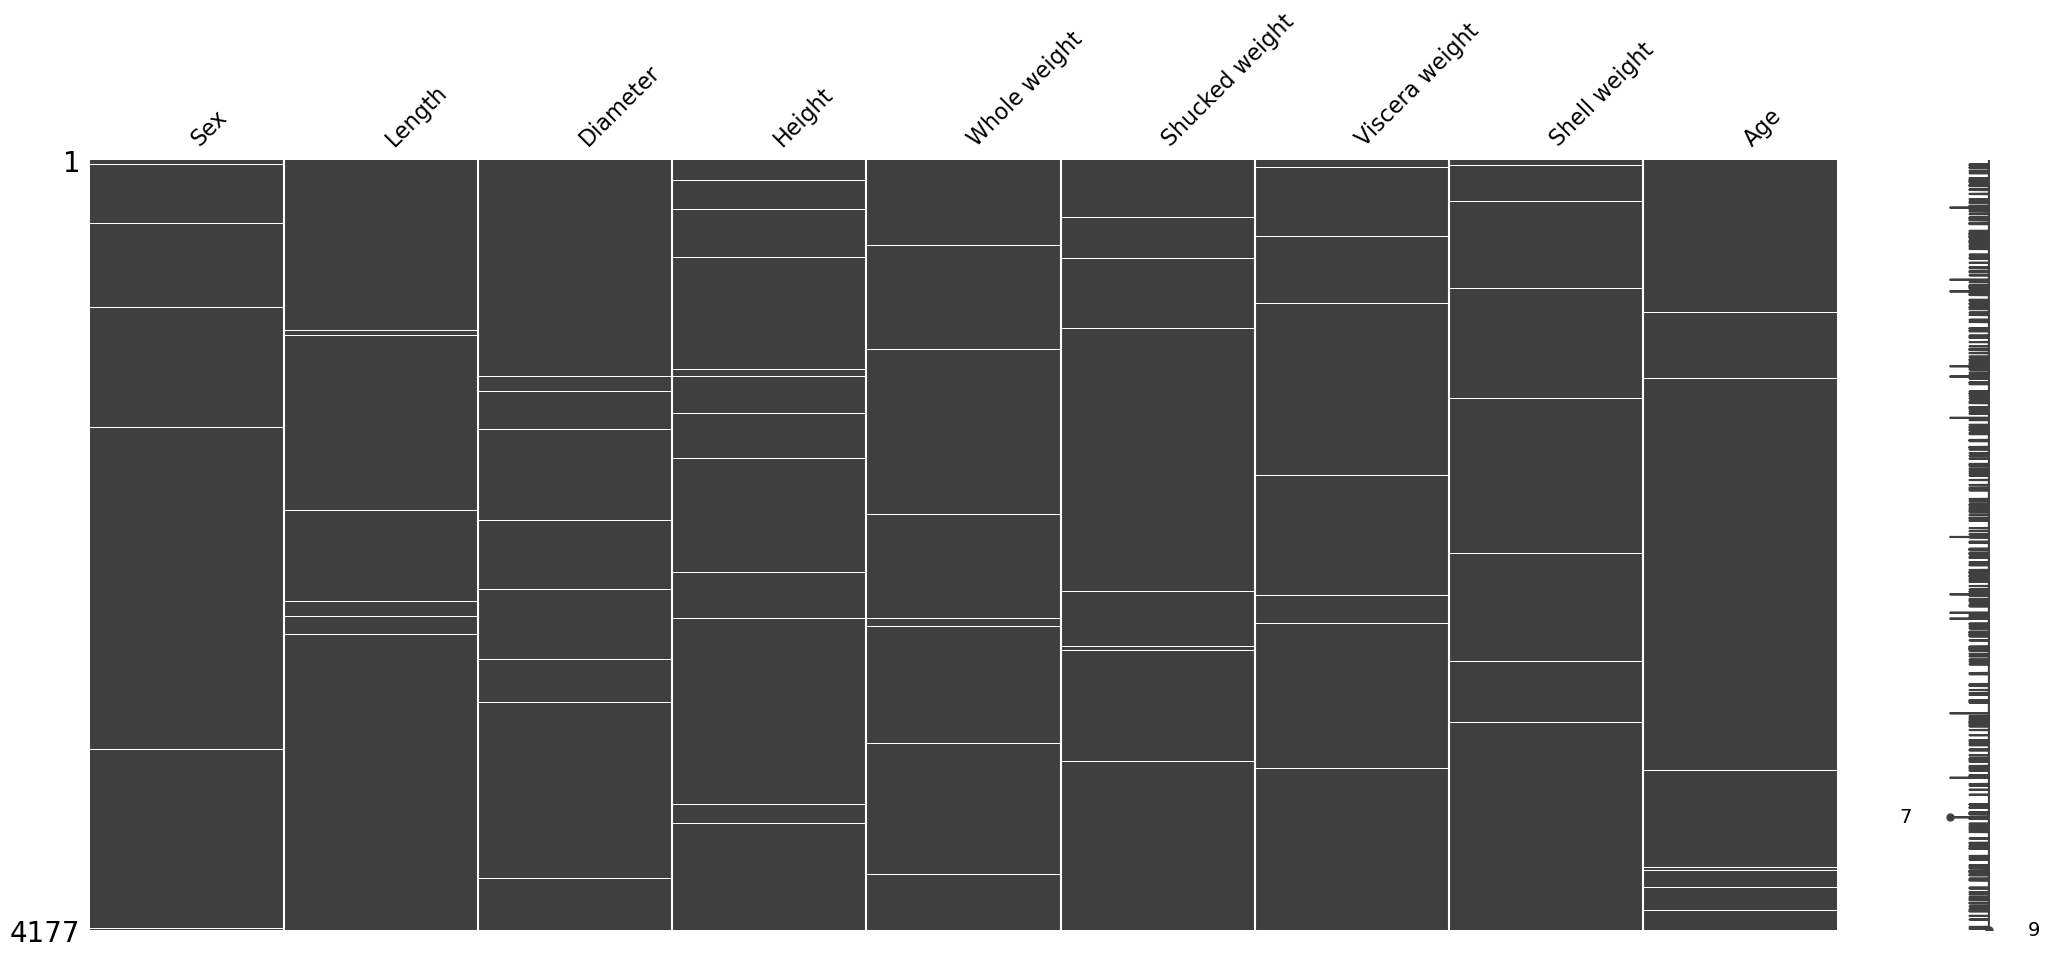

In [14]:
msno.matrix(abalone_data)

Atadığımız NaN'lar rastegele olduğu için kayıp gözlemler arasında bir korelasyon olmasını beklemiyoruz.

<Axes: >

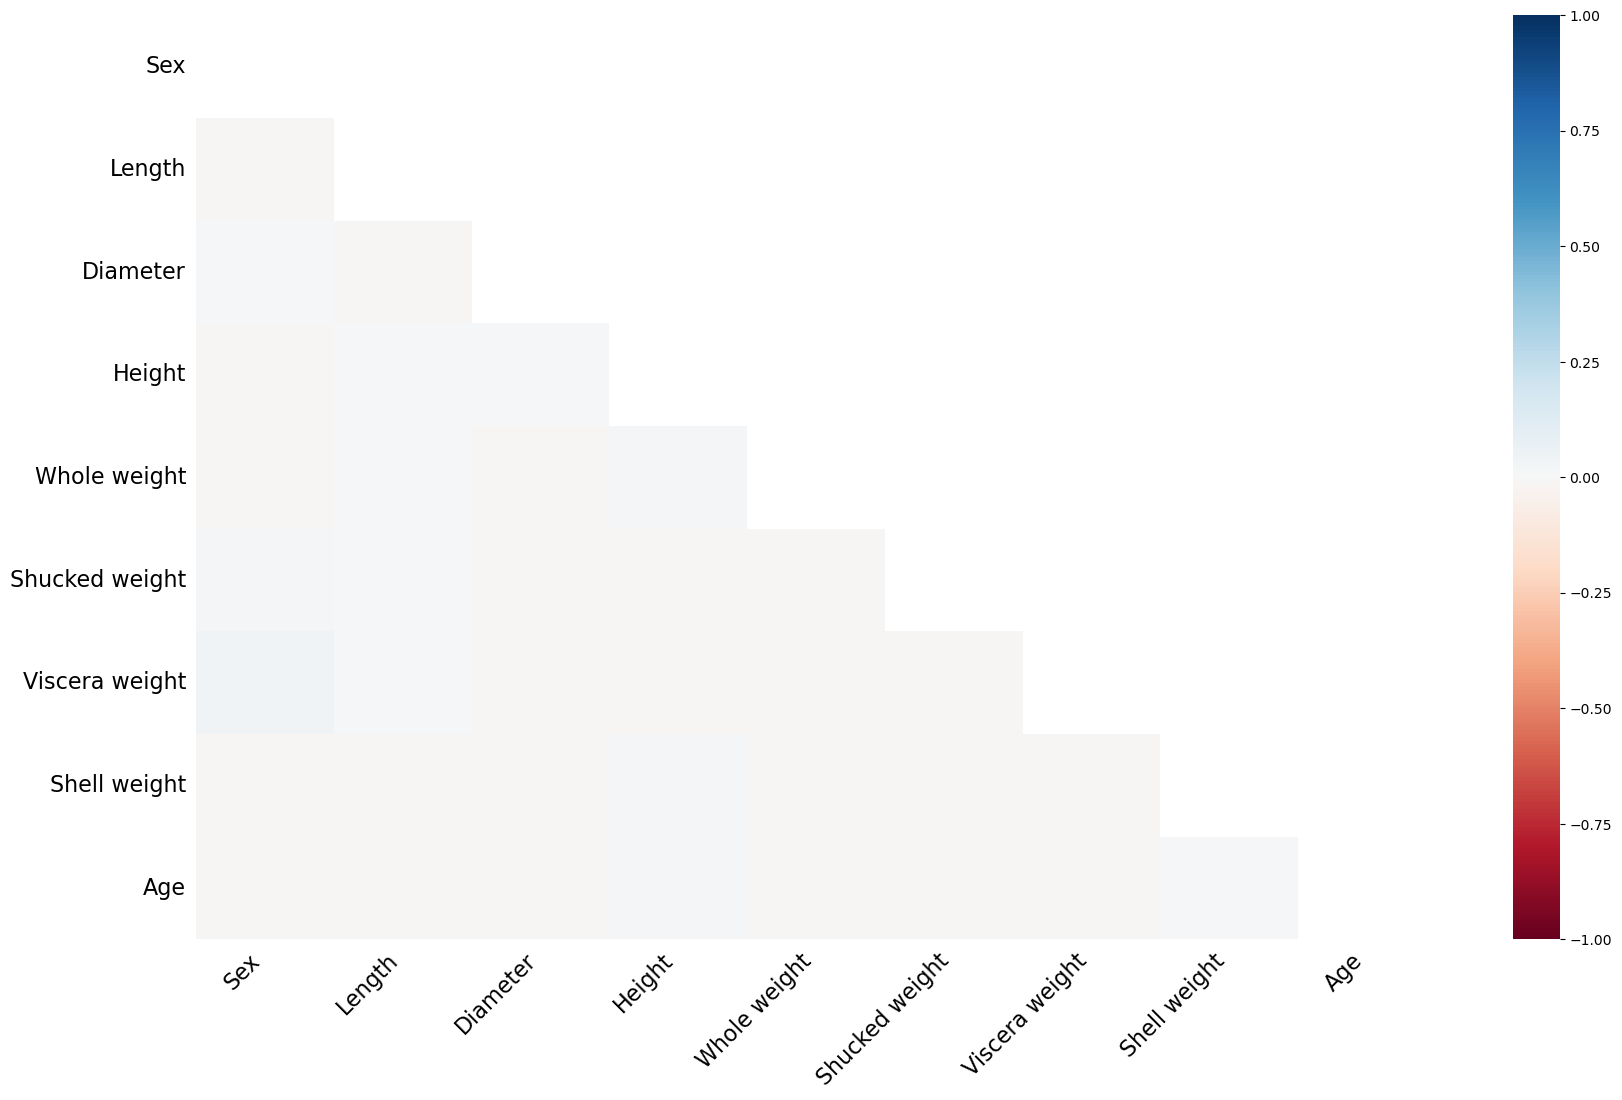

In [15]:
msno.heatmap(abalone_data) 

Kayıp gözlemleri, her sütunun(değişkenin) kendi ortalaması ile dolduruyorum.

In [16]:
abalone_data = abalone_data.apply(lambda x: x.fillna(x.mean()))
abalone_data

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,1.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,16.5
1,1.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,8.5
2,2.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,10.5
3,1.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,11.5
4,3.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,8.5
...,...,...,...,...,...,...,...,...,...
4172,2.0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,12.5
4173,1.0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,11.5
4174,1.0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,10.5
4175,2.0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,11.5


In [17]:
abalone_data.isnull().sum().sum()

0

Aşağıda değişkenlerle ilgili önemli istatistiki bilgileri görebiliyoruz.

In [18]:
abalone_data.describe()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,1.955314,0.523918,0.407786,0.139496,0.829684,0.359699,0.180672,0.239142,11.428399
std,0.824774,0.119481,0.098625,0.041664,0.488494,0.221132,0.109029,0.138725,3.201742
min,1.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,2.500000
25%,1.000000,0.450000,0.350000,0.115000,0.445000,0.188000,0.094500,0.130000,9.500000
50%,2.000000,0.540000,0.420000,0.140000,0.806000,0.340000,0.172000,0.235000,11.428399
75%,3.000000,0.615000,0.480000,0.165000,1.150000,0.500500,0.251500,0.327000,12.500000
max,3.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,30.500000


<Axes: >

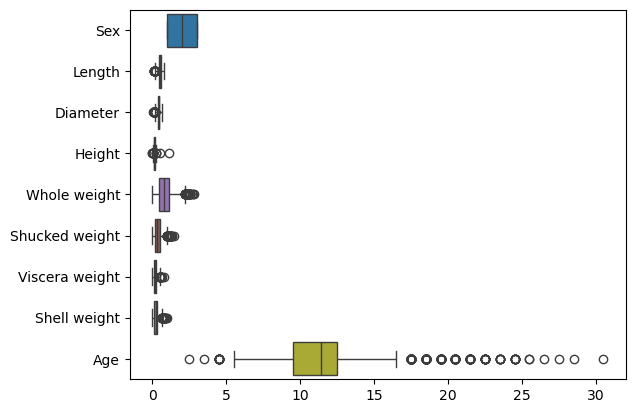

In [19]:
sns.boxplot(abalone_data[list(abalone_data.columns)], orient="h")

Aykırı değerleri aşağıdaki gibi bulabiliriz.

In [20]:
def outliers(variable_name):
    Q1 = np.percentile(abalone_data[variable_name], 25)
    Q3 = np.percentile(abalone_data[variable_name], 75)
    IQR = Q3 - Q1
    Lower_bound = (Q1 - 1.5*IQR) 
    Upper_bound = (Q3 + 1.5*IQR)
    
    Lower_outliers = abalone_data[variable_name][(abalone_data[variable_name] < Lower_bound)]
    Higher_outliers = abalone_data[variable_name][(abalone_data[variable_name] > Upper_bound)]
    
    return Lower_outliers, Higher_outliers

'Age' değişkeni için aykırı değerlere bakalım.

In [21]:
print(outliers("Age"))

(236     2.5
237     4.5
238     4.5
306     4.5
520     4.5
526     4.5
719     3.5
720     4.5
894     4.5
1054    4.5
1429    4.5
2115    4.5
2371    4.5
2711    4.5
3472    4.5
3521    4.5
3801    4.5
Name: Age, dtype: float64, 6       21.5
7       17.5
9       20.5
32      19.5
33      20.5
        ... 
3929    17.5
3930    22.5
3931    18.5
3944    21.5
3947    17.5
Name: Age, Length: 260, dtype: float64)


Bütün değişkenler arasındaki ilişkiye aşağıdaki gibi bakılabilir fakat fazla değişkenimiz olduğu için ekrana yazdırmıyorum.

In [22]:
#sbn.pairplot(abalone_data[list(abalone_data)])

Eğer istediğimiz değişkenler arasındaki ilişkiye bakmak istersek aşağıdaki fonksiyonu kullanabiliriz.

In [23]:
def correlation_plot(variable_name1, variable_name2):
    return sbn.jointplot(x = variable_name1,
             y = variable_name2,
             data = abalone_data,
             kind = "reg")

## 1.Basit Doğrusal Regresyon
&ensp;<sup>[İçeriğe git.](#İçerik)</sup>

Basit doğrusal regresyon modelimizde kullanacağım bağımsız değişkeni 'Shell weight' olarak seçiyorum. Bağımlı değişkenimiz ise 'Age'.

In [24]:
slr_variables = abalone_data.loc[:, ['Shell weight', 'Age']]
slr_variables.head()

,Shell weight,Age
0,0.150,16.5
1,0.070,8.5
2,0.210,10.5
3,0.155,11.5
4,0.055,8.5


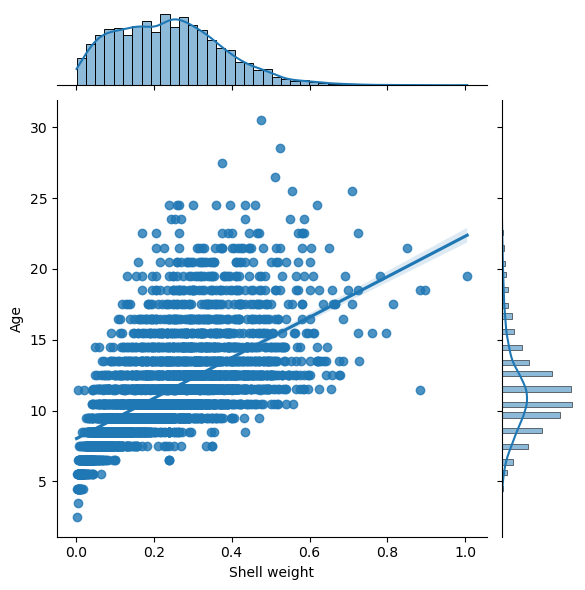

In [25]:
sns.jointplot(x="Shell weight", y="Age", data=slr_variables, kind="reg")

Modelimizi oluşturmadan önce verimizi eğitim ve test seti olarak bölüyoruz.

In [26]:
slr_train, slr_test = train_test_split(slr_variables,
                                       train_size = 0.8,
                                       test_size = 0.2,
                                       random_state = 121521014)

%80'e %20 böldüğümüz veriden, eğitim setine 3341 ve test setine 836 gözlem düştüğünü görebiliyoruz.

In [27]:
len(slr_train), len(slr_test)

(3341, 836)

Bağımsız değişken için ayrı bağımlı değişken için ayrı eğitim ve test serileri oluşturalım.

In [28]:
X_train = slr_train['Shell weight']
y_train = slr_train['Age']
X_test = slr_test['Shell weight']
y_test = slr_test['Age']

Kullanacağımız yöntemi adlandıralım.

In [29]:
sLR = LinearRegression()

Modeli oluşturmadan önce boyut düzenlemeleri yapıyoruz.

In [30]:
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

Modeli oluşturalım ve fit edelim.

In [31]:
sLR_Model = sLR.fit(X_train, y_train)

 Sabit katsayı:

In [32]:
sLR_Model.intercept_

8.014116077330247

Eğim katsayısı:

In [33]:
sLR_Model.coef_

array([14.30008561])

 Belirtme katsayısına($R^2$) baktığımızda modelin tahminlerinin iyi olmayacağını söyleyebiliriz.

In [34]:
sLR_Model.score(X_train, y_train)

0.38462834474038676

Modeli aşağıdaki gibi görselleştirebiliriz.

(0.0, 29.7)

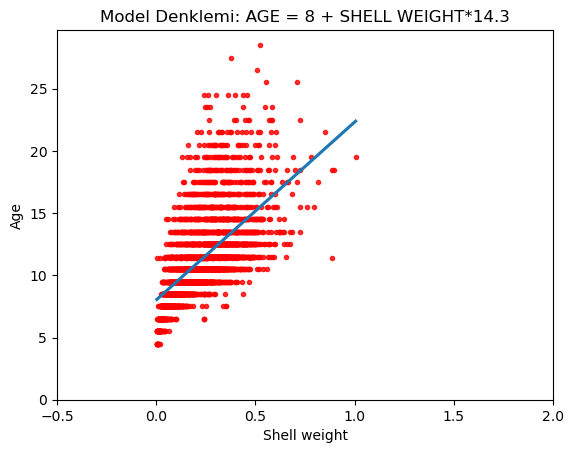

In [35]:
graph = sns.regplot(x="Shell weight", y="Age", data=slr_train, ci= None,
        scatter_kws={"color":"r", "s":9})
graph.set_title("Model Denklemi: AGE = 8 + SHELL WEIGHT*14.3")
graph.set_ylabel("Age")
graph.set_xlabel("Shell weight")
plt.xlim(-0.5, 2)
plt.ylim(bottom = 0)

Bağımsız değişken eğitim seti üzerinden tahmin değerleri elde edelim.

In [36]:
y_hat_train = pd.DataFrame(sLR_Model.predict(X_train), index = y_train.index)

Eğitim setinin gerçek değerleri ve tahmin edilen değerleri ile ilgili bir tablo oluşturalım.  
Bu tablo hata, hatalar karesi ve orantılı hataları göstermekte.

In [37]:
df_train = pd.concat([y_train, y_hat_train], axis = 1)

In [38]:
def residuals(df):
    df.columns = ["Real Age", "Predicted Age"]
    df["Residual"] = df["Real Age"] - df["Predicted Age"]
    df["SQR Residual"] = df["Residual"]**2
    df["Proportional Residual"] = abs(df["Residual"]/df["Real Age"])
    np.mean(df["SQR Residual"])
    np.mean(df["Proportional Residual"])
    np.median(df["Proportional Residual"])
    return df.head()

In [39]:
residuals(df_train)

,Real Age,Predicted Age,Residual,SQR Residual,Proportional Residual
2417,11.428399,8.586120,2.842279,8.078551,0.248703
3589,12.500000,13.898601,-1.398601,1.956086,0.111888
1255,8.500000,9.529925,-1.029925,1.060746,0.121168
2733,8.500000,9.515625,-1.015625,1.031494,0.119485
469,22.500000,14.663656,7.836344,61.408289,0.348282


Bağımsız değişken test seti üzerinden tahmin değerleri elde edelim.

In [40]:
y_hat_test = pd.DataFrame(sLR_Model.predict(X_test), index = y_test.index)

Test setinin gerçek değerleri ve tahmin edilen değerleri ile ilgili bir tablo oluşturalım.  

In [41]:
df_test = pd.concat([y_test, y_hat_test], axis = 1)

In [42]:
residuals(df_test)

,Real Age,Predicted Age,Residual,SQR Residual,Proportional Residual
2283,8.5,9.801627,-1.301627,1.694232,0.153133
2826,10.5,10.209179,0.290821,0.084577,0.027697
2238,9.5,9.587125,-0.087125,0.007591,0.009171
428,22.5,13.376648,9.123352,83.235548,0.405482
3689,10.5,13.376648,-2.876648,8.275105,0.273966


Test setinden tahmin edilen değişkenleri ve hata değerlerini görselleştirelim. 
Büyük bir hata oranına sahip olduğunu söyleyebiliriz.

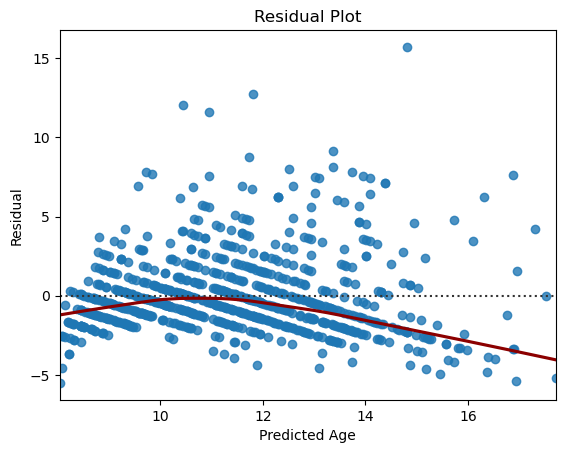

In [43]:
sns.residplot(x=y_hat_test, y=df_test["Residual"], lowess = True, line_kws=dict(color="darkred"))
plt.title('Residual Plot')
plt.xlabel('Predicted Age')
plt.show()

## 2.Çoklu Doğrusal Regresyon
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

Modelimizi oluşturmadan önce verimizi eğitim ve test seti olarak bölüyoruz.

In [44]:
abalone_DF_train, abalone_DF_test = train_test_split(abalone_data,
                                         test_size=0.2,
                                         random_state=121521014)

Bütün değişkenler sayısal olduğu için hepsini 0 ve 1 arasında ölçeklendirelim. 
Bu işlem için Minmax normalizasyonu yapalım.

In [45]:
scalerMM = MinMaxScaler()

In [46]:
abalone_data.describe()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,1.955314,0.523918,0.407786,0.139496,0.829684,0.359699,0.180672,0.239142,11.428399
std,0.824774,0.119481,0.098625,0.041664,0.488494,0.221132,0.109029,0.138725,3.201742
min,1.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,2.500000
25%,1.000000,0.450000,0.350000,0.115000,0.445000,0.188000,0.094500,0.130000,9.500000
50%,2.000000,0.540000,0.420000,0.140000,0.806000,0.340000,0.172000,0.235000,11.428399
75%,3.000000,0.615000,0.480000,0.165000,1.150000,0.500500,0.251500,0.327000,12.500000
max,3.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,30.500000


In [47]:
variables = list(abalone_DF_train.columns)

In [48]:
abalone_DF_train[variables] = scalerMM.fit_transform(abalone_DF_train[variables])
abalone_DF_test[variables] = scalerMM.transform(abalone_DF_test[variables])

In [49]:
abalone_DF_train.describe()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
count,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000
mean,0.472126,0.588425,0.568765,0.123772,0.292526,0.265585,0.238021,0.236407,0.289350
std,0.412081,0.168890,0.176228,0.037639,0.172711,0.162131,0.143040,0.138847,0.133663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.489362,0.464286,0.101770,0.155634,0.138673,0.123766,0.128743,0.208333
50%,0.500000,0.617021,0.598214,0.123894,0.284827,0.251761,0.227123,0.233034,0.288683
75%,1.000000,0.716312,0.696429,0.146018,0.405501,0.370412,0.331139,0.321357,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Bağımsız değişkenlerimiz için ayrı bağımlı değişkenimiz için ayrı eğitim ve test serileri oluşturalım.

In [50]:
a_y_train = abalone_DF_train.pop("Age")
a_X_train = abalone_DF_train

In [51]:
a_y_test = abalone_DF_test.pop("Age")
a_X_test = abalone_DF_test

#### 2.1.Özellik Eliminasyonu (Feature Selection)
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

Özyinelemeli Özelliğin Eliminasyonu(RFE) yöntemini de kullanarak bir doğrusal regresyon modeli oluşturalım ve fit edelim.

In [52]:
lm_RFE = LinearRegression()

In [53]:
lm_RFE.fit(a_X_train, a_y_train)

LinearRegression()

In [54]:
len(a_X_train.columns)

8

6 bağımsız değişken seçelim.

In [55]:
rfe = RFE(lm_RFE, n_features_to_select = 6)
rfe = rfe.fit(a_X_train, a_y_train)

RFE'nin seçtiği değişkenler aşağıdaki gibi görülebilir.

In [56]:
list(zip(a_X_train.columns, rfe.support_, rfe.ranking_))

[('Sex', False, 3),
 ('Length', False, 2),
 ('Diameter', True, 1),
 ('Height', True, 1),
 ('Whole weight', True, 1),
 ('Shucked weight', True, 1),
 ('Viscera weight', True, 1),
 ('Shell weight', True, 1)]

Seçtiğimiz değişkenlerle tahminlerde bulunalım.

In [57]:
y_pred_train = rfe.predict(a_X_train)
y_pred_test = rfe.predict(a_X_test)

RMSE ve MAPE değerini aşağıdaki fonksiyon ile hesaplayabiliriz.

In [58]:
def RMSE(actual, predicted):
    MSE = mean_squared_error(actual, predicted)
    RMSE = np.sqrt(MSE)
    return RMSE

In [59]:
def MAE(actual, predicted):
    MAE = np.mean(np.abs((actual - predicted)))
    return MAE

In [60]:
def MAPE(actual, predicted):
    MAPE = np.mean(np.abs((actual - predicted) / actual))
    return MAPE

Hem gerçek hem de tahmin değerleri normalleştrilmiş olduğundan normalizayon işleminin tersini almamıza gerek yok. Eğer almak isteseydik Minmax normalizayonunun tersi aşağıdaki gibi alınabilir.

In [61]:
#y_pred_train_inv = y_pred_train * (max(y_pred_train) - min(y_pred_train)) + min(y_pred_train)
#y_pred_test_inv = y_pred_test * (max(y_pred_test) - min(y_pred_test)) + min(y_pred_test)

Eğitim seti tahminleri için RMSE ve $R^2$ değerlerinde bakalım. 
RMSE, değeri büyük değil. 0'a yakınlık modelin uyumunun fazla olduğu anlamına geliyor.
$R^2$ değeri kötüdür. Model iyi tahmin yapamamaktadır. İlişkinin yaklaşık olarak %50'sini açıklayabilmektedir.

In [62]:
RMSE_lm_train = RMSE(a_y_train, y_pred_train)
print(RMSE_lm_train)

0.09506914022944844


In [63]:
R2_lm_train = r2_score(a_y_train, y_pred_train)
R2_lm_train

0.4939568443999556

Test seti tahminleri için RMSE ve $R^2$ değerlerinde bakalım. 
Değerler için eğitim setiyle aynı yorumlarda bulunabiliriz.   
Ayrıca yaptığımız MAE değeri de büyük değil. 0'a yakınlık modelin uyumunun fazla olduğu anlamına geliyor.

In [64]:
RMSE_lm_test = RMSE(a_y_test, y_pred_test)
print(RMSE_lm_test)

0.09340857882340643


In [65]:
R2_lm_test = r2_score(a_y_test, y_pred_test)
R2_lm_test

0.5018197912233097

In [66]:
MAE_lm_test = MAE(a_y_test, y_pred_test)
MAE_lm_test

0.066177457242716

Test setinden tahmin edilen değişkenleri ve hata değerlerini görselleştirelim. 
Büyük bir hata oranına sahip olduğunu söyleyebiliriz.

In [67]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted
    sns.residplot(x=actual, y=residuals, lowess = True, line_kws=dict(color="darkred"))
    plt.title('Residual Plot')
    plt.xlabel('Predicted Age')
    plt.ylabel('Residuals')
    plt.show()

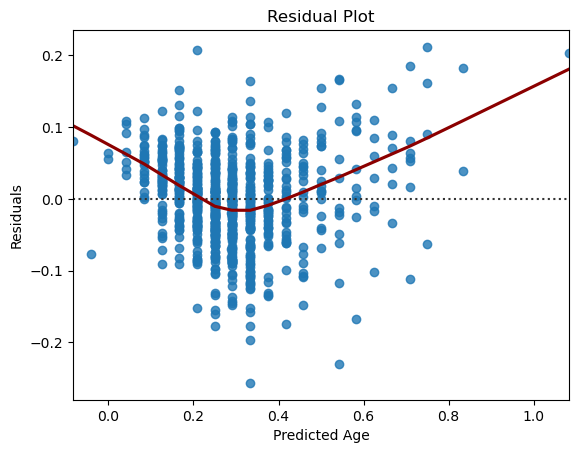

In [68]:
plot_residuals(a_y_test, y_pred_test)

### 2.2.K-Fold
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

K-fold ile subsetler oluşturup cross_val_score ile performansına bakalım.

In [69]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 121521014)

$R^2$ değerleri her subset için aşağıdaki gibidir. Performans oldukça düşüktür.

In [70]:
lm_CV0 = LinearRegression()
scores_CV0 = cross_val_score(lm_CV0, a_X_train, a_y_train,
    scoring='r2', cv=folds)
scores_CV0

array([0.48456065, 0.51201015, 0.43860337, 0.52463094, 0.44717822])

MSE, değerleri büyük değil. 0'a yakınlık modelin uyumunun fazla olduğu anlamına geliyor.

In [71]:
lm_CV1 = LinearRegression()
scores_CV2 = cross_val_score(lm_CV1, a_X_train, a_y_train,
    scoring='neg_mean_squared_error', cv=folds)
scores_CV2

array([-0.00903091, -0.01014118, -0.00976259, -0.00804762, -0.00913481])

#### 2.3.Grid Search Cross-Validation ile Hiperparametre Ayarlama
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

Çapraz doğrulamada kullanacağımız subsetleri oluşturalım.

In [72]:
fold_CVGS = KFold(n_splits=5, shuffle=True, random_state=121521014)

Seçilecek bağımsız değişken sayısını belirlemek için ilgili hiperparametrenin potansiyel değerlerini belirleyelim.

In [73]:
hyper_params_CVGS = [{"n_features_to_select": list(range(1, 9))}]

Doğrusal regresyon modelini oluşturup fit ettikten sonra RFE yöntemini de kullanarak bir GridSearch modeli oluşturalım.

In [74]:
lm_CVGS = LinearRegression()
lm_CVGS.fit(a_X_train, a_y_train)
rfe_CVGS = RFE(lm_CVGS)

In [75]:
model_CVGS = GridSearchCV(estimator = rfe_CVGS,
                         param_grid= hyper_params_CVGS,
                         scoring="r2",
                         cv=fold_CVGS,
                         verbose=1,
                         return_train_score=True)

Modeli fit edelim.

In [76]:
model_CVGS.fit(a_X_train, a_y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=121521014, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='r2', verbose=1)

Model sonuçlarına bakalım.

In [77]:
results_CVGS = pd.DataFrame(model_CVGS.cv_results_)
results_CVGS

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.012909,0.004157,0.004059,0.002054,1,{'n_features_to_select': 1},0.380117,0.378662,-0.093868,0.404471,...,0.284933,0.190039,8,0.385331,0.385602,0.371367,0.379310,0.391067,0.382536,0.006710
1,0.013165,0.005053,0.002962,0.002423,2,{'n_features_to_select': 2},0.390252,0.390341,0.301003,0.416546,...,0.372770,0.039322,7,0.392095,0.391488,0.399846,0.385561,0.397788,0.393356,0.005052
2,0.012388,0.002296,0.006597,0.003679,3,{'n_features_to_select': 3},0.464083,0.486986,0.298217,0.498960,...,0.430413,0.073778,6,0.467898,0.460067,0.480689,0.459458,0.481395,0.469901,0.009573
3,0.012113,0.005074,0.003944,0.001984,4,{'n_features_to_select': 4},0.472683,0.495760,0.326329,0.499132,...,0.442017,0.065026,5,0.477206,0.469325,0.487503,0.470545,0.489711,0.478858,0.008429
4,0.009906,0.003261,0.001036,0.002073,5,{'n_features_to_select': 5},0.473559,0.511734,0.416181,0.517533,...,0.470646,0.040468,4,0.496470,0.485248,0.495679,0.485779,0.504923,0.493620,0.007371
5,0.007948,0.002242,0.002052,0.002514,6,{'n_features_to_select': 6},0.475280,0.513587,0.414135,0.515245,...,0.471013,0.040476,3,0.497939,0.486671,0.497280,0.488072,0.506229,0.495238,0.007170
6,0.006132,0.002162,0.002936,0.003854,7,{'n_features_to_select': 7},0.484169,0.508463,0.438016,0.515528,...,0.478572,0.031471,2,0.507671,0.487755,0.504599,0.488137,0.515719,0.500776,0.011088
7,0.007210,0.002362,0.003819,0.001922,8,{'n_features_to_select': 8},0.484561,0.512010,0.438603,0.524631,...,0.481397,0.034113,1,0.507683,0.499169,0.504609,0.497872,0.515806,0.505028,0.006464


Farkı daha iyi görebilmek için sonuçları görselleştirelim. 8 değişkenin performansının en iyi olduğu görülebiliyor.

In [78]:
def opt_num_of_features(results_CVGS):
    plt.figure(figsize=(16,6));
    plt.plot(results_CVGS["param_n_features_to_select"], 
             results_CVGS["mean_train_score"]);
    plt.plot(results_CVGS["param_n_features_to_select"], 
             results_CVGS["mean_test_score"]);
    plt.xlabel('number of features');
    plt.ylabel('r-squared');
    plt.title("Optimal Number of Features");
    plt.legend(['test score', 'train score'], loc='upper left');
    return plt.show()

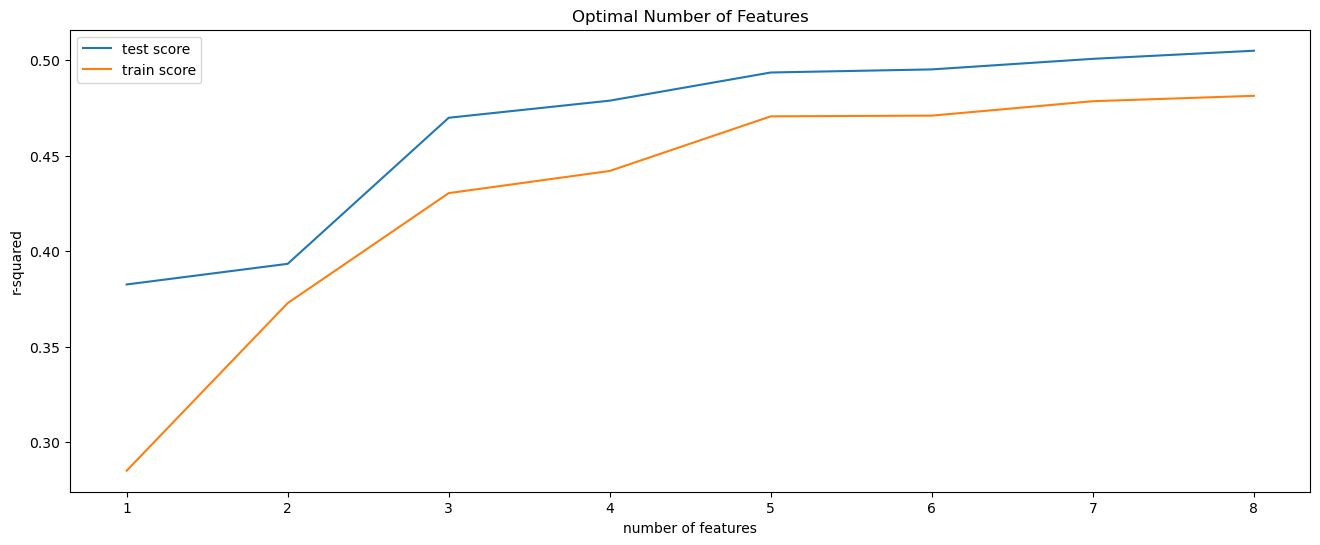

In [79]:
opt_num_of_features(results_CVGS)

Değişken sayımızı 8 olarak seçtiğimzde $R^2$ değerinin çok az arttığı görülebilir.

In [80]:
n_features_optimal = 8
lm_final = LinearRegression()
lm_final.fit(a_X_train, a_y_train)
rfe_final = RFE(lm_final, n_features_to_select=n_features_optimal)
rfe_final = rfe_final.fit(a_X_train, a_y_train)

In [81]:
y_pred_test_final = lm_final.predict(a_X_test)

In [82]:
RMSE_lm_test_final = RMSE(a_y_test, y_pred_test_final)
print(RMSE_lm_test_final)

0.09307253136263738


In [83]:
R2_lm_test_final = r2_score(a_y_test, y_pred_test_final)
R2_lm_test_final

0.5053978577036267

## 3.Çoklu Doğrusal Olmayan Regresyon
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

Bağımlı değişkenlerimizi y ve bağımsız değişkenlerimizi X olarak tanımlayalım.

In [84]:
y = abalone_data["Age"]
X = abalone_data.drop("Age", axis='columns')

Eğitim ve test olarak bölelim.

In [85]:
abalone_X_train, abalone_X_test, abalone_y_train, abalone_y_test = train_test_split(X, y,
                                                                                    test_size=0.2,
                                                                                    random_state=121521014)

Standartlaştırma ile veriyi ölçeklendirelim.

In [86]:
scalerANN = StandardScaler()

In [87]:
abalone_X_train_scaled = scalerANN.fit_transform(abalone_X_train)
abalone_X_test_scaled = scalerANN.transform(abalone_X_test)

In [88]:
abalone_y_train = np.array(abalone_y_train)
abalone_y_test = np.array(abalone_y_test)

abalone_y_train = abalone_y_train.reshape(-1, 1)
abalone_y_test = abalone_y_test.reshape(-1, 1)

In [89]:
abalone_y_train_scaled = scalerANN.fit_transform(abalone_y_train)
abalone_y_test_scaled = scalerANN.transform(abalone_y_test)

In [90]:
abalone_y_train_scaled_1d = abalone_y_train_scaled.ravel()

Çok Katmanlı Algılaycı(MLP) regresyon modelimizi oluşturalım.

In [320]:
aNN = MLPRegressor(max_iter=250, random_state=121521014).fit(abalone_X_train_scaled, abalone_y_train_scaled_1d)

Hata değerini hatalar karesi ile heapladığını, gizli katmanda 100 nöron olduğunu, 8 değişkenimizin olduğunu ve 200 iterasyon ayptığımızı görebiliriz.   
(Model hatası 200 iterasyonda 0'a tam olarak yaklaşılamadığını belirtiyor.)

In [321]:
#?aNN
aNN.loss, aNN.loss_, aNN.hidden_layer_sizes, aNN.n_features_in_, aNN.n_iter_

('squared_error', 0.20162756489251066, (100,), 8, 234)

Hatanın zamanla 0'a yaklaştığını aşağıdaki grafikten görebiliriz.

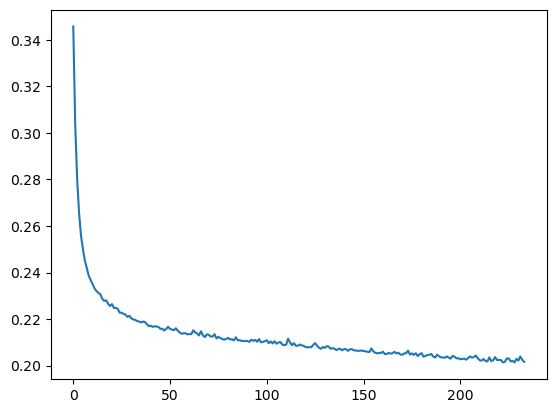

In [322]:
plt.plot(aNN.loss_curve_)

In [323]:
y_aNN_pred_train = aNN.predict(abalone_X_train_scaled)
y_aNN_pred_test = aNN.predict(abalone_X_test_scaled)

In [324]:
y_aNN_pred_train = y_aNN_pred_train.reshape(1, -1)
y_aNN_pred_test = y_aNN_pred_test.reshape(1, -1)

Hataları hesaplamadan önce tahmin değerlerinin standartlaştırılmış halini tersine çeviriyoruz.

In [325]:
y_aNN_pred_train_inv = scalerANN.inverse_transform(y_aNN_pred_train)
y_aNN_pred_test_inv = scalerANN.inverse_transform(y_aNN_pred_test)

In [326]:
y_aNN_pred_train_inv = y_aNN_pred_train_inv.reshape(-1, 1)
y_aNN_pred_test_inv = y_aNN_pred_test_inv.reshape(-1, 1)

Eğitim seti tahminleri için RMSE ve $R^2$ değerlerinde bakalım. 
RMSE, değeri 0'dan büyük yani model uyumlu değil. 
$R^2$ değeri kötüdür. Model iyi tahmin yapamamaktadır. İlişkinin yaklaşık olarak %60'ını açıklayabilmektedir. (Doğrusal regresyona kıyasla RMSE ve $R^2$ değerleri artmıştır.)

In [327]:
aNN_RMSE_train = RMSE(abalone_y_train, y_aNN_pred_train_inv)
print(aNN_RMSE_train)

2.038591509244177


In [328]:
aNN_R2_train = r2_score(abalone_y_train, y_aNN_pred_train_inv)
aNN_R2_train

0.5960325608251144

Test seti tahminleri için RMSE ve $R^2$ değerlerinde bakalım.
Eğitim seti ile aynı yorumlar yapılabilir. $R^2$ değeri daha düşüktür.

In [329]:
aNN_RMSE_test = RMSE(abalone_y_test, y_aNN_pred_test_inv)
print(aNN_RMSE_test)

2.1019999913276957


In [330]:
aNN_R2_test = r2_score(abalone_y_test, y_aNN_pred_test_inv)
aNN_R2_test

0.562018388000804

Test setinden tahmin edilen değişkenleri ve hata değerlerini görselleştirelim. Hata oranının küçük olduğu söylenemez.

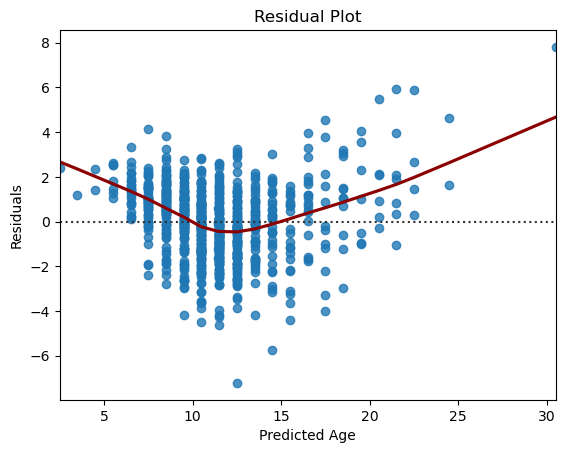

In [331]:
plot_residuals(abalone_y_test, y_aNN_pred_test_inv)

#### 3.1.Grid Search Cross-Validation ile Hiperparametre Ayarlama
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

Hiperparametre ayarlamak adına bazı değişkenler için potansiyel değerler belirliyoruz. 

In [291]:
aNN_params = {'random_state': [418],
              'hidden_layer_sizes': [(50, 50), (100,100), (100,)],
              'alpha': [0.1, 0.001, 0.0001]}

In [292]:
aNNfCV = MLPRegressor(random_state=121521014)

In [293]:
abalone_y_train_scaled_1d = abalone_y_train_scaled.ravel()

Izgara Arama Çapraz Doğrulama yapyoruz. (10 fold)

In [294]:
aNN_CVGS = GridSearchCV(aNNfCV, aNN_params,
                        cv=10,
                        n_jobs=-1,
                        verbose=2).fit(abalone_X_train_scaled, abalone_y_train_scaled_1d)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


En iyi parametrelere bakıyoruz. alpha değeri varsayılan 0.0001 değerinden 0.1'e ve hidden_layer_sizes varsayılan (100,)'den (100, 100)'e değişti.

In [295]:
aNN_CVGS.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': (100, 100), 'random_state': 418}

Modelimizi en iyi parametre değerleriyle oluşturuyoruz.

In [296]:
aNN_CVGS_model = MLPRegressor(random_state=aNN_CVGS.best_params_["random_state"],
                              hidden_layer_sizes=aNN_CVGS.best_params_["hidden_layer_sizes"],
                              alpha=aNN_CVGS.best_params_["alpha"]).fit(abalone_X_train_scaled, 
                                                                        abalone_y_train_scaled_1d)

Hatanın zamanla 0'a yaklaştığını aşağıdaki grafikten görebiliriz. Parametreleri tune etmeden önceki halinde 200'üncü iterasyonda bile 0'a yaklaşamazken, bu haliyle yaklaşık 100 iterasyonda 0'a yaklaştığını görebiliyoruz.

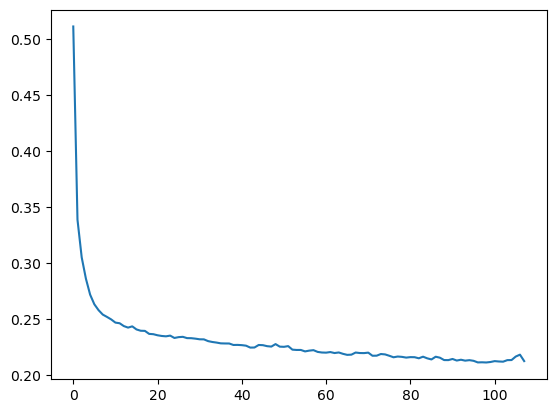

In [297]:
plt.plot(aNN_CVGS_model.loss_curve_)

In [298]:
y_pred_aNN_CVGS_train = aNN_CVGS_model.predict(abalone_X_train_scaled)
y_pred_aNN_CVGS_test = aNN_CVGS_model.predict(abalone_X_test_scaled)

In [299]:
y_pred_aNN_CVGS_train = y_pred_aNN_CVGS_train.reshape(1, -1)
y_pred_aNN_CVGS_test = y_pred_aNN_CVGS_test.reshape(1, -1)

Hataları hesaplamadan önce tahmin değerlerinin standartlaştırılmış halini tersine çeviriyoruz.

In [300]:
y_pred_aNN_CVGS_train_inv = scalerANN.inverse_transform(y_pred_aNN_CVGS_train)
y_pred_aNN_CVGS_test_inv = scalerANN.inverse_transform(y_pred_aNN_CVGS_test)

In [301]:
y_pred_aNN_CVGS_train_inv = y_pred_aNN_CVGS_train_inv.reshape(-1, 1)
y_pred_aNN_CVGS_test_inv = y_pred_aNN_CVGS_test_inv.reshape(-1, 1)

Eğitim seti tahminleri için RMSE ve $R^2$ değerlerinde bakalım. 
RMSE, değeri 0'dan büyük yani model uyumlu değil. 
$R^2$ değeri kötüdür. Model iyi tahmin yapamamaktadır. Model ilişkinin yaklaşık olarak %61'ini açıklayabilmektedir. Tune edilmemiş haline göre performans artmıştır.

In [302]:
aNN_CVGS_RMSE_train = RMSE(abalone_y_train, y_pred_aNN_CVGS_train_inv)
aNN_CVGS_RMSE_train

1.9965041407526043

In [303]:
aNN_CVGS_R2_train = r2_score(abalone_y_train, y_pred_aNN_CVGS_train_inv)
aNN_CVGS_R2_train

0.6125404500336715

Test seti tahminleri için RMSE ve $R^2$ değerlerinde bakalım.
RMSE değeri tune edilmemiş haline kıyasla daha büyüktür. Performans kötüleşmiştir. $R^2$ değeri tune edilmemiş haline göre daha küçüktür. Model yaklaşık olarak %56'sını açıklayabilmektedir.

In [304]:
aNN_CVGS_RMSE_test = RMSE(abalone_y_test, y_pred_aNN_CVGS_test_inv)
aNN_CVGS_RMSE_test

2.1046394512216926

In [305]:
aNN_CVGS_R2_test = r2_score(abalone_y_test, y_pred_aNN_CVGS_test_inv)
aNN_CVGS_R2_test

0.5609177593475658

Performans, eğitim seti için artmış fakat test seti için azalmıştır.  
(Aynı parametrelerle random_state eklemeden denediğimde hidden_layer_sizes değerinin (50, 50) seçildiği ve hem eğitim hem de test seti performansının arttığı bir durum oldu. RMSE her ikisi için de azalırken $R^2$ değerleri arttı. $R^2$ sırasıyla 0.63 ve 0.568'di.)

Test setinden tahmin edilen değişkenleri ve hata değerlerini görselleştirelim. Hata oranının küçük olduğu söylenemez.

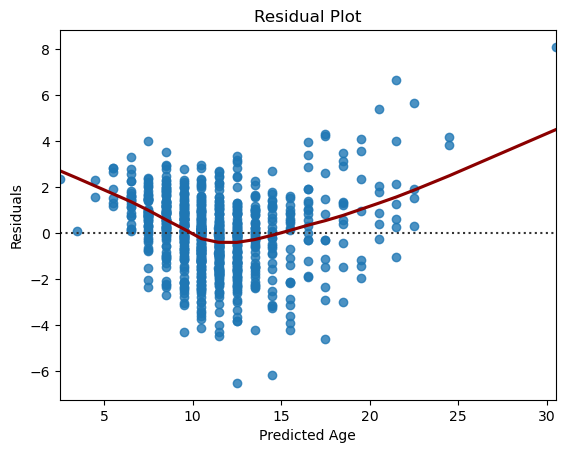

In [306]:
plot_residuals(abalone_y_test, y_pred_aNN_CVGS_test_inv)

## 4.K-En Yakın Komşular Algoritması
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

Modelimizi oluşturup fit ediyoruz.

In [252]:
kNN = KNeighborsRegressor().fit(abalone_X_train_scaled, abalone_y_train_scaled)

'minowski'(p=2) metriğini kullanıyoruz. 5 komşu kullanıldığını ve ağırlıklandırma yöteminin 'uniform' olduğunu görebiliyoruz.

In [254]:
#?kNN
kNN.metric, kNN.n_neighbors, kNN.p, kNN.weights

('minkowski', 5, 2, 'uniform')

In [255]:
y_pred_kNN_train = kNN.predict(abalone_X_train_scaled)
y_pred_kNN_test = kNN.predict(abalone_X_test_scaled)

Hataları hesaplamadan önce tahmin değerlerinin standartlaştırılmış halini tersine çeviriyoruz.

In [256]:
y_pred_kNN_train_inv = scalerANN.inverse_transform(y_pred_kNN_train)
y_pred_kNN_test_inv = scalerANN.inverse_transform(y_pred_kNN_test)

Gerçek ve tahmin değerlerinin ideal uyuma sahip olup olmadığını aşağıdaki foknsiyonu kullanarak bulabiliriz.

In [257]:
def plot_kNN(actual, predicted):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, label='Predicted vs Actual')
    plt.plot([min(actual), max(actual)], 
             [min(actual), max(actual)], color='red', linestyle="dashed", linewidth=2, label='Ideal fit')
    plt.title('KNN Regression: Predicted vs Actual')
    plt.xlabel('Actual Age Progression')
    plt.ylabel('Predicted Age Progression')
    plt.legend()
    return plt.show()

İdeal uyuma yakınlık fazla değil.

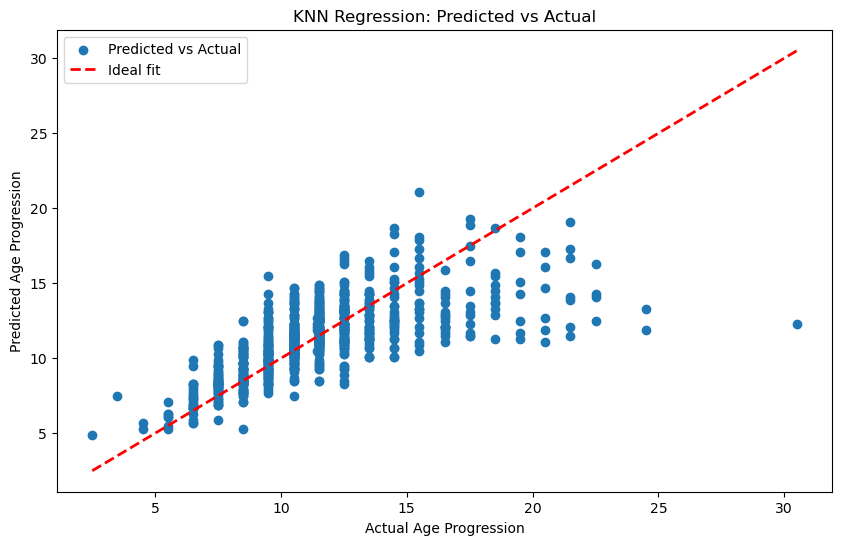

In [258]:
plot_kNN(abalone_y_test, y_pred_kNN_test_inv)

Eğitim seti tahminleri için RMSE ve $R^2$ değerlerinde bakalım. 
RMSE, değeri 0'dan büyük yani model uyumlu değil. 
$R^2$ değeri kötüdür. Model iyi tahmin yapamamaktadır. İlişkinin yaklaşık olarak %65'ini açıklayabilmektedir. (Diğer modellere göre $R^2$ değeri daha iyidir.)

In [259]:
kNN_RMSE_train = RMSE(abalone_y_train, y_pred_kNN_train_inv)
kNN_RMSE_train

1.9025994333434617

In [260]:
kNN_R2_train = r2_score(abalone_y_train, y_pred_kNN_train_inv)
kNN_R2_train

0.6481312766436943

Test seti tahminleri için RMSE ve $R^2$ değerlerinde bakalım. 
$R^2$ değeri daha eğitim setine göre çok daha düşüktür. Overfit durumu olabilir.

In [261]:
kNN_RMSE_test = RMSE(abalone_y_test, y_pred_kNN_test_inv)
kNN_RMSE_test

2.320130129886025

In [262]:
kNN_R2_test = r2_score(abalone_y_test, y_pred_kNN_test_inv)
kNN_R2_test

0.46640082940297967

#### 4.1.Grid Search Cross-Validation ile Hiperparametre Ayarlama
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

Hiperparametre ayarlamak adına bazı değişkenler için potansiyel değerler belirliyoruz.

In [307]:
kNN_params = {"n_neighbors":np.arange(1,30,1),
              "weights": ["uniform", "distance"],
              "p":[1, 2]}

In [308]:
kNNfCV = KNeighborsRegressor()

Izgara Arama Çapraz Doğrulama yapyoruz.

In [309]:
kNN_CVGS = GridSearchCV(kNN, kNN_params).fit(abalone_X_train_scaled, abalone_y_train_scaled)

En iyi parametrelere bakıyoruz.

In [310]:
kNN_CVGS.best_params_

{'n_neighbors': 27, 'p': 2, 'weights': 'distance'}

Modelimizi en iyi parametre değerleriyle oluşturuyoruz.

In [312]:
kNN_CVGS_model = KNeighborsRegressor(n_neighbors=kNN_CVGS.best_params_["n_neighbors"], 
                                     weights=kNN_CVGS.best_params_["weights"],
                                     p=kNN_CVGS.best_params_["p"]).fit(abalone_X_train_scaled, 
                                                                     abalone_y_train_scaled)

In [313]:
y_pred_kNN_CVGS_train = kNN_CVGS_model.predict(abalone_X_train_scaled)
y_pred_kNN_CVGS_test = kNN_CVGS_model.predict(abalone_X_test_scaled)

In [314]:
y_pred_kNN_CVGS_train_inv = scalerANN.inverse_transform(y_pred_kNN_CVGS_train)
y_pred_kNN_CVGS_test_inv = scalerANN.inverse_transform(y_pred_kNN_CVGS_test)

İdeal uyuma yakınlık parametre ayarı yapılmadan önceki halinden daha iyidir.

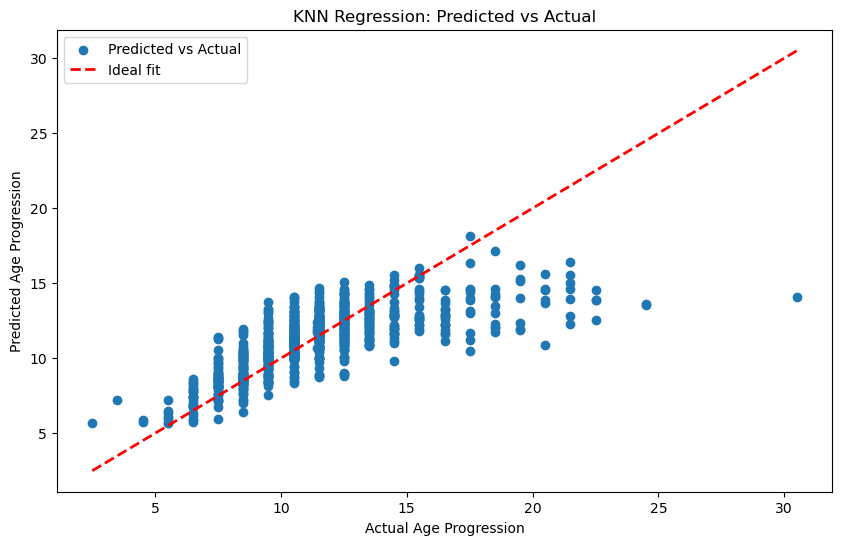

In [315]:
plot_kNN(abalone_y_test, y_pred_kNN_CVGS_test_inv)

Eğitim seti tahminleri için RMSE ve $R^2$ değerlerinde bakalım.   
RMSE, değeri oldukça düşüktür. Model uyumludur.
$R^2$ değeri mükemmeldir. İlişkinin yaklaşık olarak %100'ünü açıklayabilmektedir.  
Eğitim seti olduğu için bu duruma iyi diyemeyiz overfit durumu olması söz konusudur.

In [316]:
kNN_CVGS_RMSE_train = RMSE(abalone_y_train, y_pred_kNN_CVGS_train_inv)
kNN_CVGS_RMSE_train

5.5403047620910447e-17

In [317]:
kNN_CVGS_R2_train = r2_score(abalone_y_train, y_pred_kNN_CVGS_train_inv)
kNN_CVGS_R2_train

1.0

Test seti tahminleri için RMSE ve $R^2$ değerlerinde bakalım. 
RMSE değeri parametre ayarı yapılmadan önceki halinden daha düşüktür.  
$R^2$ değeri parametre ayarı yapılmadan önceki halinden daha yüksektir fakat diğer modellere kıyasla performansı düşüktür.

In [318]:
kNN_CVGS_RMSE_test = RMSE(abalone_y_test, y_pred_kNN_CVGS_test_inv)
kNN_CVGS_RMSE_test

2.212777534956045

In [319]:
kNN_CVGS_R2_test = r2_score(abalone_y_test, y_pred_kNN_CVGS_test_inv)
kNN_CVGS_R2_test

0.5146377835555165

Test seti sonuçlarına bakacak olursak en başarılı model, tune edilmemiş Çok Katmanlı Algılaycı(MLP) regresyon modelidir. Tune edildiğinde çok daha az iterasyonla yakın bir sonuca ulaşılabilir.